# Semi-Supervised Learning

## Contents
- [Introduction](#introduction)
- [Consistency Regularization Methods](#consistency-regularization-methods)
    - [Pi-Model](#pi-model)
        - [Training of the Pi-Model](#training-of-the-pi-model)
        - [Pi-Model: Code Implementation](#pi-model-code-implementation)
        - [Limitations of the Pi-Model](#limitations-of-the-pi-model)
    - [Temporal Ensembling](#temporal-ensembling)
    - [Temporal Ensembling: Code Implementation](#temporal-ensembling-code-implementation)

The Datasets used for this tutorial can be found here:
- [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist)

--------

## Introduction

<p align="center">
    <img src="semi_supervised_images/ssl1.png" width="400"/>
</p>

Semi Supervised Learning, 즉 준지도학습은 적은 양의 labeled 데이터와 많은 양의 unlabeled 데이터가 있다면 unlabeled 데이터 까지 활용하여 모델을 학습하는 방법론들의 집합이다.

준지도학습에서는 데이터의 본질적인 특성이 모델링 된다면, 소량의 labeled 데이터를 약간의 가이드 형식으로만 활용하여 전체적인 일반화 성능을 끌어올릴 수 있다는 전제를 두고 있다. 그렇기에 대부분의 준지도학습 모델의 손실함수는 두개의 term 이 결합된 형태이다.

$$
L = L_{supervised} + L_{unsupervised}
$$

데이터의 본질적인 특성의 모델링을 통한 성능향상 방법론이기에, 먼저 데이터에 대한 몇가지 가정이 필요하다.

1. Smoothness Assumption

    만약 데이터스페이스 상에서 두 샘플 $x_1, x_2$ 가 가깝다면, 이에 대응하는 정답 label $y_1, y_2$ 또한 가깝다.

2. Cluster Assumption

    데이터스페이스에는 높은 density 를 가진 영역과 낮은 density 를 가진 영역이 존재한다. 높은 density 를 가진 영역에는 대게 같은 label 을 가진 샘플들이 군집되어있다.

3. Low Density Assumption

    두개의 클래스를 구분짓는 분류경계면은 낮은 density region 을 통과한다. SVM 에서 Margin 을 최대화 하는 분류경계면을 최적의 경계면으로 채택하는 개념과 일맥상통한다.

4. Manifold Assumption

    고차원의 데이터의 특성을 그대로 유지하는 저차원의 manifold 가 존재한다.

**이 중에서 가장 중요한 가정을 고르자면 모든 가정을 관통하는 Smoothness Assumption 이다.**

## Consistency Regularization Methods

준지도학습의 taxonomy 를 확인해보면 GAN based 생성모델 기반 학습, Graph 기반 학습 등 다양한 갈래가 존재하지만, 해당 튜토리얼은 Consistency Regularization Methods 을 다루고자 한다.

Consistency Regularization Methods 는 이미지 도메인에서 많이 쓰이는 준지도학습 방법론들이며, unlabeled 샘플에 작은 perturbation 을 주어도 모델 자체의 예측은 일관성이 있을 거라는 가정 하에 출발한다.

그렇기에 labeled 샘플에 대해서는 일반적으로 잘 맞추도록 학습되며, unlabeled 샘플에 대해서는 약간의 perturbation 을 준 샘플과 차이가 크지 않도록 학습이 된다. 이때 labeled 샘플에 대해서는 cross entropy 와 같은 일반적인 지도학습 손실함수가 사용되며, unlabeled 샘플에 대해서는 MSE, KL Divergence, Jensen Shannon Divergence 등 minimizing term 손실함수가 사용된다.

### Pi-Model


<p align="center">
    <img src="semi_supervised_images/piarchitecture.png" width="400"/>
</p>

Pi Model 은 2017년 ICLR 에서 소개된 방법론이며, Consistency Regularization 의 큰 개념을 설명하는데 가장 적합하다 판단하여 먼저 다루고자 한다.

> 본 논문에서는 특이하게도 output 을 $z_i$ 라고 표기하며, 샘플 $x_i$ 에 대한 정답 label 을 $y_i$ 로 표기한다. Perturbation 이 가해진 객체는 $\tilde{z}$ 로 표기한다.

네트워크 구조는 위와 같으며, 인풋 샘플에 대해 주는 stochastic augmentation (perturbation) 이 핵심이다. 각 Batch 기준으로 모델이 학습되는 원리는 다음과 같다.

#### Training of the Pi-Model

1. 하나의 샘플에 대해 아주 작은 perturbation 을 준 두개의 샘플을 생성한다.
2. 두개의 샘플을 같은 네트워크에 통과시킨다. 이때, 네트워크는 하나이지만 (같은 parameter) 각 샘플이 통과될 때 다른 dropout 이 적용된다.
3. 두개의 샘플에 대한 두개의 모델의 예측 pair $(x_i, z_i), (\tilde{x_i}, \tilde{z_i})$ 을 생성한다.
4. 둘중 아무 쌍 $(x_i, z_i)$ 이나 이용해서 supervised loss 를 계산하고, 두 쌍의 output $(z_i, \tilde{z_i})$ 을 통해 unsupervised loss 를 계산한 뒤, parameter 을 업데이트 한다. 이때 supervised loss 는 해당 batch 안에 있는 labeled 샘플에 대해서만 계산이 되며 ($B \cap L$), unsupervised loss 는 batch 속 모든 샘플에 대해서 계산이 된다.

<p align="center">
    <img src="semi_supervised_images/pialg.png" width="400"/>
</p>

이때 supervised loss 는 cross entropy 를 사용하며, unsupervised loss 는 MSE 를 사용한다.

실제로 loss 가 계산되는 term 을 확인해보면 cross entropy 와 MSE 의 결합으로 계산되는데, unsupervised weigth ramp up function $w(t)$ 이라는 term 이 MSE를 scaling 하는 것을 확인 할 수 있다. 이 weight ramp up function 은 단조증가하는 임의의 함수이며, 학습 시작점에선 0에 근접한다.

다른 dropout 과 perturbation (gaussian) 을 사용했기 때문에 두개의 output $(z_i, \tilde{z_i})$ 은 다르지만, 실제론 굉장히 가깝기에 MSE 를 계산하는것이 일리가 있다.

#### Pi-Model: Code Implementation

In [1]:
import os
import platform
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import scienceplots
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

plt.style.use(['science', 'notebook', 'grid'])

if platform.system() == 'Darwin':
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Operating system: {platform.system()}, Device: {device}')

Operating system: Darwin, Device: mps


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


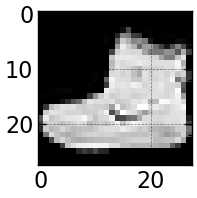

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

sample_img = train_data[0][0]
plt.figure(figsize=(2,2))
plt.imshow(sample_img.permute(1,2,0), cmap='gray');

class_names = train_data.classes
class_dict = train_data.class_to_idx
print(class_dict)

사용한 데이터셋은 10개의 패션 아이템을 모아둔 FashionMNIST다. MNIST 와 동일하게 60,000개의 train 샘플, 10,000개의 test sample 로 이루어져 있으며 이미지는 동일하게 28 by 28 차원이다.

In [3]:
n = len(train_data)
rrng = np.random.RandomState(42)
indices = torch.zeros(100)
others = torch.zeros(n - 100)
card = 100 // len(class_names)
cpt = 0

for i in range(len(class_names)):
    class_items = (train_data.train_labels == i).nonzero()
    n_class = len(class_items)
    rd = rrng.permutation(np.arange(n_class))
    indices[i * card: (i+1) * card] = torch.squeeze(class_items[rd[:card]])
    others[cpt: cpt+n_class-card] = torch.squeeze(class_items[rd[card:]])
    cpt += (n_class-card)

others = others.long()
train_data.train_labels[others] = -1

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=64,
                                            num_workers=0,
                                            shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=64,
                                            num_workers=0,
                                            shuffle=False,
                                            drop_last=True)

/Users/jonghyunlee/miniforge3/envs/pythonic/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
no_label_train = [i for i in train_data.targets if i == -1]
no_label_test = [i for i in test_data.targets if i == -1]
print(f'Number of unlabeled samples in train data: {len(no_label_train)}')
print(f'Number of unlabeled samples in test data: {len(no_label_test)}')

Number of unlabeled samples in train data: 59900
Number of unlabeled samples in test data: 0


FashionMNIST 데이터는 60,000개의 학습 샘플과 10,000개의 테스트 샘플을 가지고 있다. 기본적으로 모든 샘플들에는 레이블이 존재하기 때문에, 임의로 학습 샘플 중 100개의 샘플만 남겨두고 나머지 59,900 개의 샘플들의 레이블을 `-1`, 즉 unlabeled 데이터로 변환하였다.

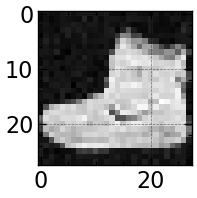

In [5]:
class GaussianNoise(nn.Module):
    def __init__(self, batch_size, input_shape, std):
        super(GaussianNoise, self).__init__()
        self.shape = (batch_size, ) + input_shape
        self.std = std
        self.noise = torch.zeros(self.shape)

    def forward(self, x):
        self.noise.normal_(mean=0, std=self.std)
        return x + self.noise
gn = GaussianNoise(1, (1, 28, 28), 0.1)
sample_perturbed_img = gn(sample_img).squeeze()
plt.figure(figsize=(2,2))
plt.imshow(sample_perturbed_img, cmap='gray');

각 input sample 에 가우시안 perturbation 을 줄 class 를 정의하였다.

In [6]:
def mse_loss(out1, out2):
    quad_diff = torch.sum((F.softmax(out1, dim=1) - F.softmax(out2, dim=1)) ** 2)
    return quad_diff / out1.data.nelement()

def masked_crossentropy(out, labels):
    cond = (labels >= 0)
    nnz = torch.nonzero(cond)
    nbsup = len(nnz)
    if nbsup > 0:
        masked_outputs = torch.index_select(out, 0, nnz.view(nbsup))
        masked_labels = labels[cond]
        loss = F.cross_entropy(masked_outputs, masked_labels)
        return loss, nbsup
    loss = torch.tensor([0.], requires_grad=False)
    return loss, 0

def temporal_losses(out1, out2, w, labels):
    sup_loss, nbsup = masked_crossentropy(out1, labels)
    unsup_loss = mse_loss(out1, out2)
    total_loss = sup_loss + w * unsup_loss
    return total_loss, sup_loss, unsup_loss, nbsup

함수 `temporal_losses` 는 supervised loss 인 `masked_crossentropy` unsupervised loss 인 `mse_loss` 와  의 wrapper 함수이다.

$$
\begin{aligned}
& \frac{1}{|B|} \sum_{i \in(B \cap L)} \log z_i\left[y_i\right] +w(t) \frac{1}{C|B|} \sum_{i \in B}\left\|z_i-\tilde{z}_i\right\|^2
\end{aligned}
$$

이때 `temporal_losses` 는 `w` 를 인자로 받는데, 이는 unsupervised weight ramp up function 이다.

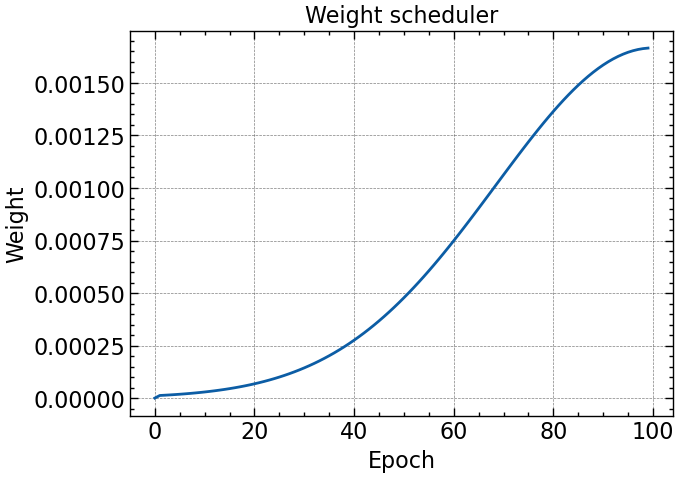

In [7]:
def weight_scheduler(epoch, max_epochs, max_val, mult, n_labeled, n_samples):
    max_val = max_val * (float(n_labeled) / n_samples)
    if epoch == 0:
        return 0.
    elif epoch >= max_epochs:
        pass
    return max_val * np.exp(-mult * (1. - float(epoch) / max_epochs) ** 2)
    
max_epochs = 100
max_val = 1.
mult = 5

x = np.arange(0, 100)
y = [weight_scheduler(i, max_epochs, max_val, mult, 100, 60000) for i in x]
plt.figure(figsize=(7, 5))
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.title('Weight scheduler');

Weight ramp up function 은 시작을 0으로 Epoch 이 진행될수록 단조증가하는 함수이다. 

$\exp(-(1 - \frac{epoch}{maxepochs})^2)$

In [8]:
class CNN_pi(nn.Module):
    def __init__(self, batch_size, std, input_shape=(1, 28, 28), p=0.5, fm1=16, fm2=32):
        super(CNN_pi, self).__init__()
        self.std = std
        self.p = p
        self.fm1 = fm1
        self.fm2 = fm2
        self.input_shape = input_shape
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, self.fm1, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm1), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(self.fm1, self.fm2, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        self.drop = nn.Dropout(self.p)
        self.fc = nn.Linear(self.fm2 * 7 * 7, 10)

    def forward(self, x):
        if self.training:
            b = x.size(0)
            gn = GaussianNoise(b, self.input_shape, self.std)
            x_2 = x.clone()
            x = gn(x)
            x_2 = gn(x_2)

        else:
            x_2 = x.clone()

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.reshape(-1, self.fm2 * 7 * 7)
        x = self.fc(self.drop(x))
        x_2 = self.conv_block1(x_2)
        x_2 = self.conv_block2(x_2)
        x_2 = x_2.reshape(-1, self.fm2 * 7 * 7)
        x_2 = self.fc(self.drop(x_2))
        return x, x_2

실제로 학습할 모델 구조는 이미지 데이터에 걸맞는 CNN 구조를 선택하였다. 각 샘플에 대해 이전에 정의한 `GaussianNoise` 클래스를 통해 perturbation 을 주입하기 위한 인자 `std` 와, 마지막 affine층에 dropout 확률을 조절할 수 있는 인자 `p` 를 정의하였다.

모델 구조는 2개의 convolutional block 과 1개의 affine layer 로 구성되어 있으며, 각 convolutional block 은 2차원 convolution, batch normalization, ReLU 활성화, 그리고 2차원 max pooling 으로 구성하였다.

학습 시에는 input 데이터를 복제 한 뒤, 각각 가우시안 perturbation 을 준 뒤, 순전파를 거친다.

In [38]:
sample_model = CNN_pi(64, 0.1)
sample_out, sample_out_2 = sample_model(sample_img)
cos_sim = F.cosine_similarity(sample_out, sample_out_2, dim=1)
print(f'Cosine similarity: {cos_sim}')

Cosine similarity: tensor([0.7822], grad_fn=<SumBackward1>)


실제로 sample image 를 순전파 하여 $z_i, \tilde{z_i}$ 가 초기에 얼마나 다른지 코사인 유사도로 확인 해 본 결과, 서로 꽤나 다른 perturbation 이 가해진 것을 볼 수 있다.

In [39]:
model = CNN_pi(batch_size=64, std=0.1)
k = 100
lr = 0.002
num_epochs = 50
batch_size = 64
n_classes = 10
max_epochs = 80
max_val = 1.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

학습을 위한 모델 파라미터는 위와 같이 설정하였다. 본 논문에서 사용 한 것 처럼 ADAM 을 optimizer 로 사용하였으며, 50 epoch 을 학습 기간으로 설정하였다.

In [41]:
def calc_metrics_pi(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        labels = labels.requires_grad_(False)
        _, outputs = model(samples)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels.detach().view_as(predicted)).sum()
    acc = 100 * float(correct) / total
    return acc

losses = []
suplosses = []
unsuplosses = []
accuracies = []
best_loss = 30.0

for epoch in range(num_epochs):
    print(f'\nEpoch: {epoch+1}')
    model.train()
    w = weight_scheduler(epoch, max_epochs, max_val, 5, k, 60000)
    w = torch.tensor(w, requires_grad=False)

    print('---------------------')
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        batch_size = images.size(0)
        labels = labels.requires_grad_(False)
        optimizer.zero_grad()
        outputs, outputs_2 = model(images)
        loss, sup_loss, unsup_loss, nbsup = temporal_losses(outputs, outputs_2, w, labels)

        losses.append(loss.item())
        suplosses.append(sup_loss.item())
        unsuplosses.append(unsup_loss.item())

        loss.backward()
        optimizer.step()

    loss_mean = np.mean(losses)
    supl_mean = np.mean(suplosses)
    unsupl_mean = np.mean(unsuplosses)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_mean:.6f}, Supervised Loss: {supl_mean:.6f}, Unsupervised Loss: {unsupl_mean:.6f}')
    if loss_mean < best_loss:
        best_loss = loss_mean
        torch.save({'state_dict': model.state_dict()}, 'model_best_pi.pth')

    model.eval()
    acc = calc_metrics_pi(model, test_loader)
    accuracies.append(acc)
    print(f'Acc : {acc}')


Epoch: 1
---------------------


0it [00:00, ?it/s]

Epoch 1/50, Loss: 0.254788, Supervised Loss: 0.254788, Unsupervised Loss: 0.016013
Acc : 47.81650641025641

Epoch: 2
---------------------


0it [00:00, ?it/s]

Epoch 2/50, Loss: 0.202058, Supervised Loss: 0.202058, Unsupervised Loss: 0.015643
Acc : 56.08974358974359

Epoch: 3
---------------------


0it [00:00, ?it/s]

Epoch 3/50, Loss: 0.167951, Supervised Loss: 0.167951, Unsupervised Loss: 0.015668
Acc : 61.05769230769231

Epoch: 4
---------------------


0it [00:00, ?it/s]

Epoch 4/50, Loss: 0.150627, Supervised Loss: 0.150627, Unsupervised Loss: 0.015632
Acc : 61.50841346153846

Epoch: 5
---------------------


0it [00:00, ?it/s]

Epoch 5/50, Loss: 0.135137, Supervised Loss: 0.135137, Unsupervised Loss: 0.015824
Acc : 58.78405448717949

Epoch: 6
---------------------


0it [00:00, ?it/s]

Epoch 6/50, Loss: 0.122791, Supervised Loss: 0.122791, Unsupervised Loss: 0.016102
Acc : 62.760416666666664

Epoch: 7
---------------------


0it [00:00, ?it/s]

Epoch 7/50, Loss: 0.113928, Supervised Loss: 0.113928, Unsupervised Loss: 0.016442
Acc : 61.83894230769231

Epoch: 8
---------------------


0it [00:00, ?it/s]

Epoch 8/50, Loss: 0.105258, Supervised Loss: 0.105258, Unsupervised Loss: 0.016501
Acc : 65.25440705128206

Epoch: 9
---------------------


0it [00:00, ?it/s]

Epoch 9/50, Loss: 0.101505, Supervised Loss: 0.101504, Unsupervised Loss: 0.016562
Acc : 65.69511217948718

Epoch: 10
---------------------


0it [00:00, ?it/s]

Epoch 10/50, Loss: 0.098282, Supervised Loss: 0.098281, Unsupervised Loss: 0.016737
Acc : 62.91065705128205

Epoch: 11
---------------------


0it [00:00, ?it/s]

Epoch 11/50, Loss: 0.092882, Supervised Loss: 0.092882, Unsupervised Loss: 0.016960
Acc : 64.9238782051282

Epoch: 12
---------------------


0it [00:00, ?it/s]

Epoch 12/50, Loss: 0.088415, Supervised Loss: 0.088414, Unsupervised Loss: 0.017134
Acc : 66.56650641025641

Epoch: 13
---------------------


0it [00:00, ?it/s]

Epoch 13/50, Loss: 0.084237, Supervised Loss: 0.084237, Unsupervised Loss: 0.017370
Acc : 67.98878205128206

Epoch: 14
---------------------


0it [00:00, ?it/s]

Epoch 14/50, Loss: 0.081133, Supervised Loss: 0.081133, Unsupervised Loss: 0.017570
Acc : 65.5048076923077

Epoch: 15
---------------------


0it [00:00, ?it/s]

Epoch 15/50, Loss: 0.076974, Supervised Loss: 0.076973, Unsupervised Loss: 0.017819
Acc : 66.53645833333333

Epoch: 16
---------------------


0it [00:00, ?it/s]

Epoch 16/50, Loss: 0.074353, Supervised Loss: 0.074352, Unsupervised Loss: 0.017953
Acc : 65.07411858974359

Epoch: 17
---------------------


0it [00:00, ?it/s]

Epoch 17/50, Loss: 0.071113, Supervised Loss: 0.071112, Unsupervised Loss: 0.018152
Acc : 66.65665064102564

Epoch: 18
---------------------


0it [00:00, ?it/s]

Epoch 18/50, Loss: 0.068794, Supervised Loss: 0.068794, Unsupervised Loss: 0.018209
Acc : 67.62820512820512

Epoch: 19
---------------------


0it [00:00, ?it/s]

Epoch 19/50, Loss: 0.065649, Supervised Loss: 0.065648, Unsupervised Loss: 0.018335
Acc : 67.6181891025641

Epoch: 20
---------------------


0it [00:00, ?it/s]

Epoch 20/50, Loss: 0.063223, Supervised Loss: 0.063223, Unsupervised Loss: 0.018488
Acc : 63.45152243589744

Epoch: 21
---------------------


0it [00:00, ?it/s]

Epoch 21/50, Loss: 0.061402, Supervised Loss: 0.061401, Unsupervised Loss: 0.018578
Acc : 69.2608173076923

Epoch: 22
---------------------


0it [00:00, ?it/s]

Epoch 22/50, Loss: 0.058907, Supervised Loss: 0.058906, Unsupervised Loss: 0.018655
Acc : 68.71995192307692

Epoch: 23
---------------------


0it [00:00, ?it/s]

Epoch 23/50, Loss: 0.056794, Supervised Loss: 0.056793, Unsupervised Loss: 0.018751
Acc : 66.46634615384616

Epoch: 24
---------------------


0it [00:00, ?it/s]

Epoch 24/50, Loss: 0.054647, Supervised Loss: 0.054646, Unsupervised Loss: 0.018837
Acc : 68.76001602564102

Epoch: 25
---------------------


0it [00:00, ?it/s]

Epoch 25/50, Loss: 0.052977, Supervised Loss: 0.052976, Unsupervised Loss: 0.018880
Acc : 67.71834935897436

Epoch: 26
---------------------


0it [00:00, ?it/s]

Epoch 26/50, Loss: 0.051546, Supervised Loss: 0.051545, Unsupervised Loss: 0.018896
Acc : 67.78846153846153

Epoch: 27
---------------------


0it [00:00, ?it/s]

Epoch 27/50, Loss: 0.049656, Supervised Loss: 0.049654, Unsupervised Loss: 0.018901
Acc : 68.40945512820512

Epoch: 28
---------------------


0it [00:00, ?it/s]

Epoch 28/50, Loss: 0.048693, Supervised Loss: 0.048691, Unsupervised Loss: 0.018926
Acc : 68.19911858974359

Epoch: 29
---------------------


0it [00:00, ?it/s]

Epoch 29/50, Loss: 0.047355, Supervised Loss: 0.047353, Unsupervised Loss: 0.018950
Acc : 69.89182692307692

Epoch: 30
---------------------


0it [00:00, ?it/s]

Epoch 30/50, Loss: 0.045927, Supervised Loss: 0.045926, Unsupervised Loss: 0.018974
Acc : 70.02203525641026

Epoch: 31
---------------------


0it [00:00, ?it/s]

Epoch 31/50, Loss: 0.044793, Supervised Loss: 0.044791, Unsupervised Loss: 0.018997
Acc : 69.71153846153847

Epoch: 32
---------------------


0it [00:00, ?it/s]

Epoch 32/50, Loss: 0.044000, Supervised Loss: 0.043999, Unsupervised Loss: 0.019014
Acc : 67.76842948717949

Epoch: 33
---------------------


0it [00:00, ?it/s]

Epoch 33/50, Loss: 0.043246, Supervised Loss: 0.043244, Unsupervised Loss: 0.019035
Acc : 67.4979967948718

Epoch: 34
---------------------


0it [00:00, ?it/s]

Epoch 34/50, Loss: 0.042505, Supervised Loss: 0.042503, Unsupervised Loss: 0.019038
Acc : 67.55809294871794

Epoch: 35
---------------------


0it [00:00, ?it/s]

Epoch 35/50, Loss: 0.041951, Supervised Loss: 0.041949, Unsupervised Loss: 0.019070
Acc : 69.79166666666667

Epoch: 36
---------------------


0it [00:00, ?it/s]

Epoch 36/50, Loss: 0.040788, Supervised Loss: 0.040786, Unsupervised Loss: 0.019065
Acc : 69.1005608974359

Epoch: 37
---------------------


0it [00:00, ?it/s]

Epoch 37/50, Loss: 0.040455, Supervised Loss: 0.040453, Unsupervised Loss: 0.019080
Acc : 70.50280448717949

Epoch: 38
---------------------


0it [00:00, ?it/s]

Epoch 38/50, Loss: 0.039619, Supervised Loss: 0.039617, Unsupervised Loss: 0.019073
Acc : 70.6630608974359

Epoch: 39
---------------------


0it [00:00, ?it/s]

Epoch 39/50, Loss: 0.039425, Supervised Loss: 0.039423, Unsupervised Loss: 0.019071
Acc : 69.94190705128206

Epoch: 40
---------------------


0it [00:00, ?it/s]

Epoch 40/50, Loss: 0.038492, Supervised Loss: 0.038489, Unsupervised Loss: 0.019084
Acc : 69.55128205128206

Epoch: 41
---------------------


0it [00:00, ?it/s]

Epoch 41/50, Loss: 0.038497, Supervised Loss: 0.038494, Unsupervised Loss: 0.019082
Acc : 69.58133012820512

Epoch: 42
---------------------


0it [00:00, ?it/s]

Epoch 42/50, Loss: 0.037783, Supervised Loss: 0.037780, Unsupervised Loss: 0.019047
Acc : 69.2207532051282

Epoch: 43
---------------------


0it [00:00, ?it/s]

Epoch 43/50, Loss: 0.037192, Supervised Loss: 0.037189, Unsupervised Loss: 0.018993
Acc : 68.16907051282051

Epoch: 44
---------------------


0it [00:00, ?it/s]

Epoch 44/50, Loss: 0.036358, Supervised Loss: 0.036354, Unsupervised Loss: 0.018956
Acc : 67.51802884615384

Epoch: 45
---------------------


0it [00:00, ?it/s]

Epoch 45/50, Loss: 0.035684, Supervised Loss: 0.035680, Unsupervised Loss: 0.018955
Acc : 68.17908653846153

Epoch: 46
---------------------


0it [00:00, ?it/s]

Epoch 46/50, Loss: 0.035076, Supervised Loss: 0.035072, Unsupervised Loss: 0.018963
Acc : 68.95032051282051

Epoch: 47
---------------------


0it [00:00, ?it/s]

Epoch 47/50, Loss: 0.034475, Supervised Loss: 0.034471, Unsupervised Loss: 0.018916
Acc : 67.97876602564102

Epoch: 48
---------------------


0it [00:00, ?it/s]

Epoch 48/50, Loss: 0.034165, Supervised Loss: 0.034161, Unsupervised Loss: 0.018924
Acc : 69.42107371794872

Epoch: 49
---------------------


0it [00:00, ?it/s]

Epoch 49/50, Loss: 0.034334, Supervised Loss: 0.034330, Unsupervised Loss: 0.018927
Acc : 69.4911858974359

Epoch: 50
---------------------


0it [00:00, ?it/s]

Epoch 50/50, Loss: 0.034173, Supervised Loss: 0.034169, Unsupervised Loss: 0.018897
Acc : 68.95032051282051


`model.device` 를 따로 할당하지 않고 일반 cpu 에서 학습 한 결과 약 40분이 걸렸으며, 최종적인 Test Accuracy 는 약 68.95 였다.

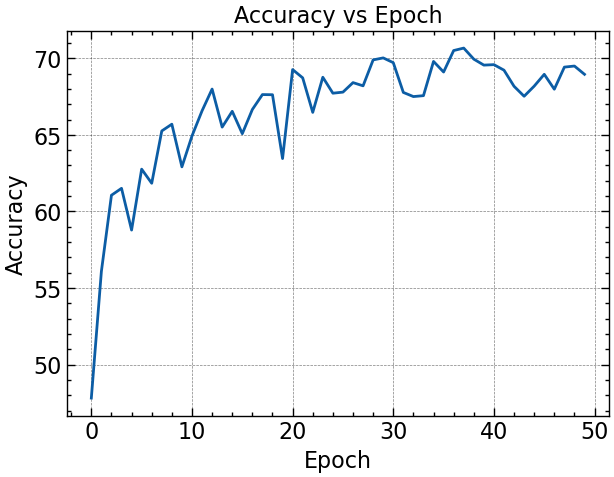

In [54]:
plt.figure(figsize=(7, 5))
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch');

#### Limitations of the Pi-Model

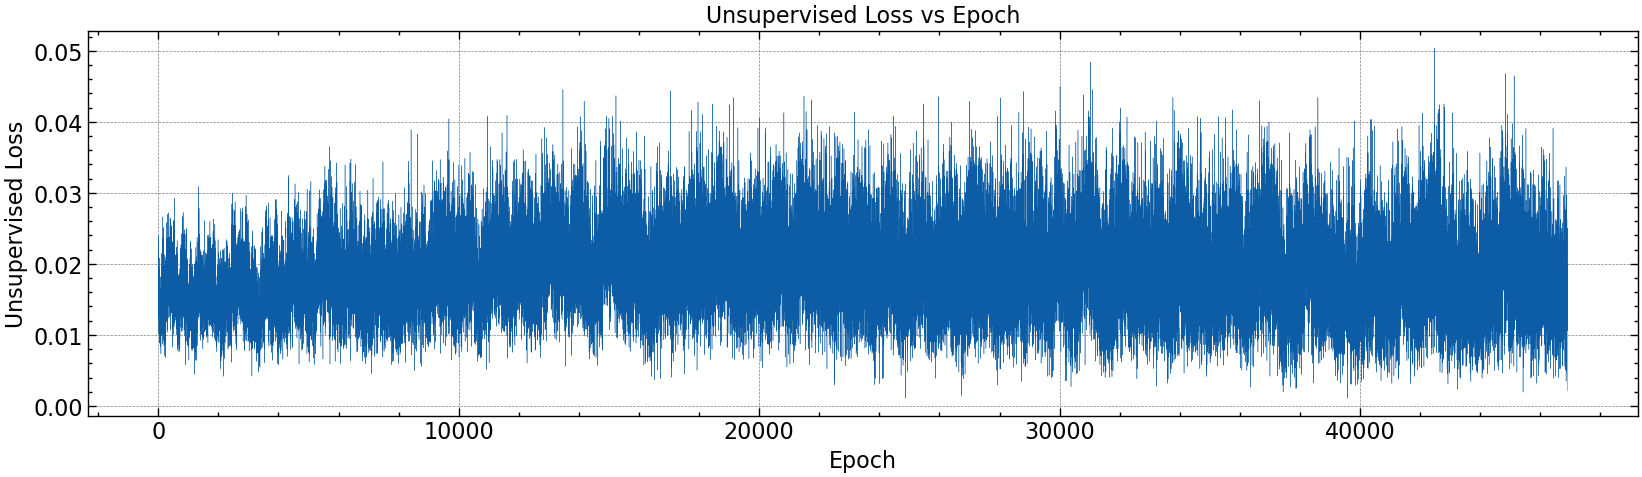

In [70]:
plt.figure(figsize=(20, 5))
plt.plot(unsuplosses, linewidth=0.3)
plt.xlabel('Epoch')
plt.ylabel('Unsupervised Loss')
plt.title('Unsupervised Loss vs Epoch');

Unsupervised loss 는 모델의 두 output $(z_i, \tilde{z_i})$ 에 대해 계산된다. 하지만 해당 output 은 단 한번의 evaluation 을 통해 생성되기 때문에 (초기엔 더더욱) noisy 하다는 단점이 있다. 그렇기에 Pi-Model 의 저자들이 동 논문에서 단점들을 보완한 Temporal Ensembling 을 제안한다.

### Temporal Ensembling

<p align="center">
    <img src="semi_supervised_images/tempensarchitecture.png" width="400"/>
</p>


Temporal Ensembling 과 Pi-Model 의 차이점은 unsupervised loss 를 계산하는 방법에서 확인 할 수 있다. Pi-Model 은 하나의 샘플에 대해 두번의 perturbation 을 주어 두개의 output $(z_i, \tilde{z_i})$ 사이의 loss 를 계산하지만, **Temporal Ensembling 은 해당 단계의 output $z_i$ 를 이전 단계들에서 구한 $z_i$ 의 가중합 사이의 loss 를 계산한다.**

즉, 특정 단계에서 MSE 를 구할 땐 해당 단계에서의 output $z_i$ 와, 이전 단계들에서 누적된 $Z$ 사이의 차이를 계산한다.

이때, $Z$ 는 $Z \leftarrow \alpha Z + (1-\alpha)z$ 로 누적되며, $\alpha$ 는 momentum term 으로, 본 논문에선 $\alpha=0.6$ 으로 설정된다.

<p align="center">
    <img src="semi_supervised_images/tempensalg.png" width="400"/>
</p>


#### Temporal Ensembling: Code Implementation

Pi-Model 과의 성능 비교를 위해 Pi-Model 을 학습하는데 사용한 FashionMNIST 데이터로더를 사용하였다.

In [71]:
class CNN_Temporal(nn.Module):
    def __init__(self, batch_size, std, input_shape=(1, 28, 28), p=0.5, fm1=16, fm2=32):
        super(CNN_Temporal, self).__init__()
        self.std = std
        self.p = p
        self.fm1 = fm1
        self.fm2 = fm2
        self.input_shape = input_shape
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, self.fm1, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm1), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(self.fm1, self.fm2, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        self.drop = nn.Dropout(self.p)
        self.fc = nn.Linear(self.fm2 * 7 * 7, 10)

    def forward(self, x):
        if self.training:
            b = x.size(0)
            gn = GaussianNoise(b, self.input_shape, self.std)
            x = gn(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, self.fm2 * 7 * 7)
        x = self.fc(self.drop(x))
        return x

모델 구조는 Pi-Model 과 크게 다르진 않지만, 두개의 output 이 필요 없다는 점에서 단 하나의 output 에 perturbation 을 가해준 뒤, 동일한 구조에 데이터를 통과시켜 순전파를 거친다.

In [72]:
def calc_metrics_temporal(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        labels = labels.requires_grad_(False)
        outputs = model(samples)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels.detach().view_as(predicted)).sum()
    acc = 100 * float(correct) / total
    return acc

model = CNN_Temporal(batch_size=64, std=0.1)
seed = 0
k = 100
alpha = 0.6
lr = 0.002
num_epochs = 50
batch_size = 64
ntrain = len(train_data)
n_classes = 10
max_epochs = 80
max_val = 1.

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

Z = torch.zeros(ntrain, n_classes).float()
z = torch.zeros(ntrain, n_classes).float()
outputs = torch.zeros(ntrain, n_classes).float()

losses_temporal = []
suplosses_temporal = []
unsuplosses_temporal = []
accuracies_temporal = []
best_loss = 30.0
for epoch in range(num_epochs):
    print(f'\nEpoch: {epoch+1}')
    model.train()
    w = weight_scheduler(epoch, max_epochs, max_val, 5, k, 60000)
    w = torch.tensor(w, requires_grad=False)
    print('---------------------')

    for i, (images, labels) in tqdm(enumerate(train_loader)):
        batch_size = images.size(0)
        labels = labels.requires_grad_(False)

        optimizer.zero_grad()
        out = model(images)
        
        zcomp = z[i * batch_size: (i+1) * batch_size]
        zcomp.requires_grad_(False)
        loss, suploss, unsuploss, nbsup = temporal_losses(out, zcomp, w, labels)

        outputs[i * batch_size: (i+1) * batch_size] = out.clone().detach()
        losses_temporal.append(loss.item())
        suplosses_temporal.append(nbsup * suploss.item())
        unsuplosses_temporal.append(unsuploss.item())

        loss.backward()
        optimizer.step()

    loss_mean = np.mean(losses_temporal)
    supl_mean = np.mean(suplosses_temporal)
    unsupl_mean = np.mean(unsuplosses_temporal)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_mean:.6f}, Supervised Loss: {supl_mean:.6f}, Unsupervised Loss: {unsupl_mean:.6f}')
    Z = alpha * Z + (1. - alpha) * outputs
    z = Z * (1. / (1. - alpha ** (epoch + 1)))

    if loss_mean < best_loss:
        best_loss = loss_mean
        torch.save({'state_dict': model.state_dict()}, 'model_best_temporal.pth')

    model.eval()
    acc = calc_metrics_temporal(model, test_loader)
    accuracies_temporal.append(acc)
    print(f'Acc : {acc}')


Epoch: 1
---------------------


0it [00:00, ?it/s]

Epoch 1/50, Loss: 0.532475, Supervised Loss: 0.534732, Unsupervised Loss: 0.058099
Acc : 51.432291666666664

Epoch: 2
---------------------


0it [00:00, ?it/s]

Epoch 2/50, Loss: 0.392608, Supervised Loss: 0.393787, Unsupervised Loss: 0.055671
Acc : 52.49399038461539

Epoch: 3
---------------------


0it [00:00, ?it/s]

Epoch 3/50, Loss: 0.319754, Supervised Loss: 0.320553, Unsupervised Loss: 0.048168
Acc : 59.60536858974359

Epoch: 4
---------------------


0it [00:00, ?it/s]

Epoch 4/50, Loss: 0.272051, Supervised Loss: 0.272690, Unsupervised Loss: 0.042733
Acc : 59.75560897435897

Epoch: 5
---------------------


0it [00:00, ?it/s]

Epoch 5/50, Loss: 0.235627, Supervised Loss: 0.236200, Unsupervised Loss: 0.038613
Acc : 63.3213141025641

Epoch: 6
---------------------


0it [00:00, ?it/s]

Epoch 6/50, Loss: 0.207151, Supervised Loss: 0.207635, Unsupervised Loss: 0.035305
Acc : 64.09254807692308

Epoch: 7
---------------------


0it [00:00, ?it/s]

Epoch 7/50, Loss: 0.187701, Supervised Loss: 0.188116, Unsupervised Loss: 0.033361
Acc : 59.485176282051285

Epoch: 8
---------------------


0it [00:00, ?it/s]

Epoch 8/50, Loss: 0.170388, Supervised Loss: 0.170752, Unsupervised Loss: 0.032042
Acc : 66.66666666666667

Epoch: 9
---------------------


0it [00:00, ?it/s]

Epoch 9/50, Loss: 0.157087, Supervised Loss: 0.157470, Unsupervised Loss: 0.030693
Acc : 64.66346153846153

Epoch: 10
---------------------


0it [00:00, ?it/s]

Epoch 10/50, Loss: 0.146792, Supervised Loss: 0.147138, Unsupervised Loss: 0.029294
Acc : 65.22435897435898

Epoch: 11
---------------------


0it [00:00, ?it/s]

Epoch 11/50, Loss: 0.136083, Supervised Loss: 0.136398, Unsupervised Loss: 0.028435
Acc : 65.69511217948718

Epoch: 12
---------------------


0it [00:00, ?it/s]

Epoch 12/50, Loss: 0.127577, Supervised Loss: 0.127865, Unsupervised Loss: 0.027735
Acc : 64.62339743589743

Epoch: 13
---------------------


0it [00:00, ?it/s]

Epoch 13/50, Loss: 0.119966, Supervised Loss: 0.120278, Unsupervised Loss: 0.027142
Acc : 67.3076923076923

Epoch: 14
---------------------


0it [00:00, ?it/s]

Epoch 14/50, Loss: 0.113181, Supervised Loss: 0.113470, Unsupervised Loss: 0.026770
Acc : 66.96714743589743

Epoch: 15
---------------------


0it [00:00, ?it/s]

Epoch 15/50, Loss: 0.106382, Supervised Loss: 0.106652, Unsupervised Loss: 0.026235
Acc : 69.82171474358974

Epoch: 16
---------------------


0it [00:00, ?it/s]

Epoch 16/50, Loss: 0.101620, Supervised Loss: 0.101873, Unsupervised Loss: 0.025850
Acc : 70.38261217948718

Epoch: 17
---------------------


0it [00:00, ?it/s]

Epoch 17/50, Loss: 0.096616, Supervised Loss: 0.096855, Unsupervised Loss: 0.025603
Acc : 68.37940705128206

Epoch: 18
---------------------


0it [00:00, ?it/s]

Epoch 18/50, Loss: 0.092417, Supervised Loss: 0.092642, Unsupervised Loss: 0.025347
Acc : 68.11899038461539

Epoch: 19
---------------------


0it [00:00, ?it/s]

Epoch 19/50, Loss: 0.087667, Supervised Loss: 0.087880, Unsupervised Loss: 0.025118
Acc : 67.29767628205128

Epoch: 20
---------------------


0it [00:00, ?it/s]

Epoch 20/50, Loss: 0.083787, Supervised Loss: 0.083989, Unsupervised Loss: 0.024905
Acc : 65.59495192307692

Epoch: 21
---------------------


0it [00:00, ?it/s]

Epoch 21/50, Loss: 0.080846, Supervised Loss: 0.081038, Unsupervised Loss: 0.024868
Acc : 68.26923076923077

Epoch: 22
---------------------


0it [00:00, ?it/s]

Epoch 22/50, Loss: 0.078186, Supervised Loss: 0.078370, Unsupervised Loss: 0.024968
Acc : 67.89863782051282

Epoch: 23
---------------------


0it [00:00, ?it/s]

Epoch 23/50, Loss: 0.075332, Supervised Loss: 0.075600, Unsupervised Loss: 0.024834
Acc : 69.86177884615384

Epoch: 24
---------------------


0it [00:00, ?it/s]

Epoch 24/50, Loss: 0.072690, Supervised Loss: 0.072946, Unsupervised Loss: 0.024677
Acc : 66.49639423076923

Epoch: 25
---------------------


0it [00:00, ?it/s]

Epoch 25/50, Loss: 0.070138, Supervised Loss: 0.070384, Unsupervised Loss: 0.024507
Acc : 67.66826923076923

Epoch: 26
---------------------


0it [00:00, ?it/s]

Epoch 26/50, Loss: 0.069347, Supervised Loss: 0.069583, Unsupervised Loss: 0.024451
Acc : 69.32091346153847

Epoch: 27
---------------------


0it [00:00, ?it/s]

Epoch 27/50, Loss: 0.067067, Supervised Loss: 0.067295, Unsupervised Loss: 0.024465
Acc : 67.0673076923077

Epoch: 28
---------------------


0it [00:00, ?it/s]

Epoch 28/50, Loss: 0.065151, Supervised Loss: 0.065370, Unsupervised Loss: 0.024413
Acc : 70.3926282051282

Epoch: 29
---------------------


0it [00:00, ?it/s]

Epoch 29/50, Loss: 0.063431, Supervised Loss: 0.063643, Unsupervised Loss: 0.024322
Acc : 67.04727564102564

Epoch: 30
---------------------


0it [00:00, ?it/s]

Epoch 30/50, Loss: 0.062168, Supervised Loss: 0.062373, Unsupervised Loss: 0.024244
Acc : 69.77163461538461

Epoch: 31
---------------------


0it [00:00, ?it/s]

Epoch 31/50, Loss: 0.060468, Supervised Loss: 0.060666, Unsupervised Loss: 0.024157
Acc : 68.21915064102564

Epoch: 32
---------------------


0it [00:00, ?it/s]

Epoch 32/50, Loss: 0.058675, Supervised Loss: 0.058866, Unsupervised Loss: 0.024028
Acc : 67.0673076923077

Epoch: 33
---------------------


0it [00:00, ?it/s]

Epoch 33/50, Loss: 0.057151, Supervised Loss: 0.057336, Unsupervised Loss: 0.023904
Acc : 68.37940705128206

Epoch: 34
---------------------


0it [00:00, ?it/s]

Epoch 34/50, Loss: 0.055489, Supervised Loss: 0.055669, Unsupervised Loss: 0.023772
Acc : 70.13221153846153

Epoch: 35
---------------------


0it [00:00, ?it/s]

Epoch 35/50, Loss: 0.053999, Supervised Loss: 0.054173, Unsupervised Loss: 0.023722
Acc : 69.94190705128206

Epoch: 36
---------------------


0it [00:00, ?it/s]

Epoch 36/50, Loss: 0.052809, Supervised Loss: 0.052978, Unsupervised Loss: 0.023670
Acc : 68.48958333333333

Epoch: 37
---------------------


0it [00:00, ?it/s]

Epoch 37/50, Loss: 0.051528, Supervised Loss: 0.051692, Unsupervised Loss: 0.023582
Acc : 69.75160256410257

Epoch: 38
---------------------


0it [00:00, ?it/s]

Epoch 38/50, Loss: 0.050207, Supervised Loss: 0.050367, Unsupervised Loss: 0.023546
Acc : 70.77323717948718

Epoch: 39
---------------------


0it [00:00, ?it/s]

Epoch 39/50, Loss: 0.049321, Supervised Loss: 0.049476, Unsupervised Loss: 0.023497
Acc : 70.92347756410257

Epoch: 40
---------------------


0it [00:00, ?it/s]

Epoch 40/50, Loss: 0.048092, Supervised Loss: 0.048244, Unsupervised Loss: 0.023374
Acc : 70.89342948717949

Epoch: 41
---------------------


0it [00:00, ?it/s]

Epoch 41/50, Loss: 0.047595, Supervised Loss: 0.047743, Unsupervised Loss: 0.023246
Acc : 70.1923076923077

Epoch: 42
---------------------


0it [00:00, ?it/s]

Epoch 42/50, Loss: 0.046885, Supervised Loss: 0.047029, Unsupervised Loss: 0.023146
Acc : 69.63141025641026

Epoch: 43
---------------------


0it [00:00, ?it/s]

Epoch 43/50, Loss: 0.045882, Supervised Loss: 0.046022, Unsupervised Loss: 0.023059
Acc : 69.68149038461539

Epoch: 44
---------------------


0it [00:00, ?it/s]

Epoch 44/50, Loss: 0.045327, Supervised Loss: 0.045463, Unsupervised Loss: 0.022934
Acc : 70.41266025641026

Epoch: 45
---------------------


0it [00:00, ?it/s]

Epoch 45/50, Loss: 0.044507, Supervised Loss: 0.044641, Unsupervised Loss: 0.022854
Acc : 68.68990384615384

Epoch: 46
---------------------


0it [00:00, ?it/s]

Epoch 46/50, Loss: 0.043618, Supervised Loss: 0.043749, Unsupervised Loss: 0.022820
Acc : 70.28245192307692

Epoch: 47
---------------------


0it [00:00, ?it/s]

Epoch 47/50, Loss: 0.042809, Supervised Loss: 0.042937, Unsupervised Loss: 0.022781
Acc : 71.06370192307692

Epoch: 48
---------------------


0it [00:00, ?it/s]

Epoch 48/50, Loss: 0.043129, Supervised Loss: 0.043254, Unsupervised Loss: 0.022704
Acc : 71.04366987179488

Epoch: 49
---------------------


0it [00:00, ?it/s]

Epoch 49/50, Loss: 0.042542, Supervised Loss: 0.042664, Unsupervised Loss: 0.022659
Acc : 68.82011217948718

Epoch: 50
---------------------


0it [00:00, ?it/s]

Epoch 50/50, Loss: 0.041720, Supervised Loss: 0.041840, Unsupervised Loss: 0.022612
Acc : 70.63301282051282


Temporal Ensembling 의 학습은 위와 같이 진행된다.
Pi-Model 과는 다르게 $Z$ 로 unsupervised loss 를 계산하기 때문에, 첫 epoch 에는 reference 할 $Z$ 가 없어 먼저 0으로 초기화를 해주었다.
```
Z = torch.zeros(ntrain, n_classes).float()
z = torch.zeros(ntrain, n_classes).float()
```
이후 한 epoch 이 지난 후, $\alpha Z + (1-\alpha)z$ 로 $Z$ 를 업데이트 해준 뒤, 다음 epoch 에서 target 으로 사용할 $z$ 를 $Z/(1-\alpha^t)$ 가중평균으로 업데이트 해주었다.

```
Z = alpha * Z + (1. - alpha) * outputs
z = Z * (1. / (1. - alpha ** (epoch + 1)))
```

$z$ 의 가중평균 momentum $\alpha = 0.6$, learning rate 0.002, batch size 64 로 총 50 epoch 동안 학습을 진행하였다.

`model.device` 를 따로 할당하지 않고 일반 cpu 에서 학습 한 결과 약 20분이 걸렸으며, 최종적인 Test Accuracy 는 약 70.63 이였다.

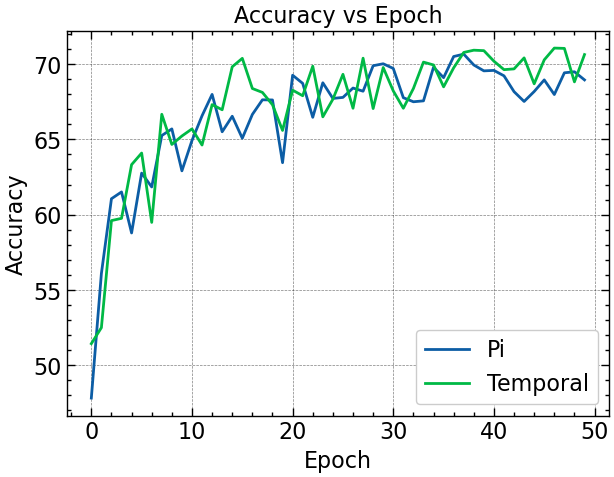

In [78]:
plt.figure(figsize=(7, 5))
plt.plot(accuracies)
plt.plot(accuracies_temporal)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Pi', 'Temporal'])
plt.title('Accuracy vs Epoch');

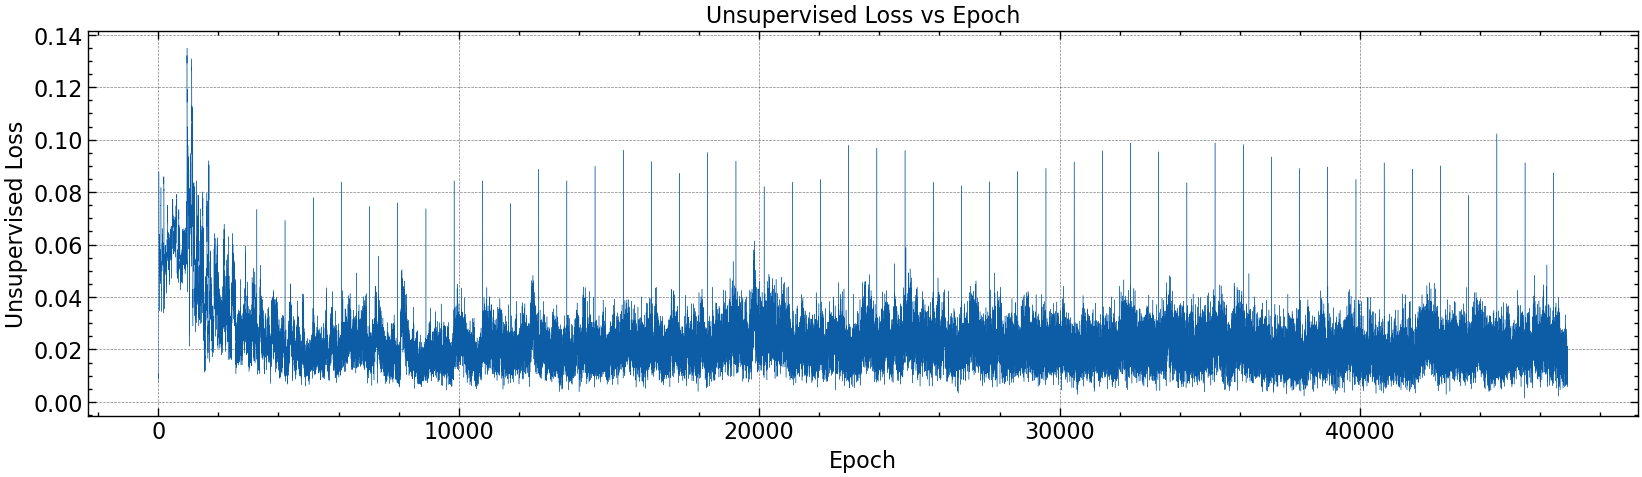

In [88]:
plt.figure(figsize=(20, 5))
plt.plot(unsuplosses_temporal, linewidth=0.3)
plt.xlabel('Epoch')
plt.ylabel('Unsupervised Loss')
plt.title('Unsupervised Loss vs Epoch');

In [90]:
def evaluation(model, loader):
    checkpoint = torch.load('model_best_temporal.pth')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    correct = 0
    total = 0
    pred_probs = []
    true_labels = []
    with torch.inference_mode():
        for i, (samples, labels) in enumerate(loader):
            labels = labels.requires_grad_(False)
            outputs = model(samples)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels.detach().view_as(predicted)).sum()
            pred_probs.append(predicted)
            true_labels.append(labels)
        acc = 100 * float(correct) / total
        print(f'Testing Accuracy: {acc:.1f}')
        pred_probs = torch.cat(pred_probs)
        labels = torch.cat(true_labels)
    return pred_probs, labels

pred_probs, labels = evaluation(model, test_loader)

Testing Accuracy: 70.6


Best Model 의 Test 데이터에 대한 Accuracy 는 약 70.6으로, 일반적인 classification task 였으면 sub-par 한 성능이였겠지만,

**총 60,000개의 학습 샘플 중 100개만 label 이 있다는 것을 감안 한다면 꽤나 준수한 성능을 보인 것을 알 수 있다.**

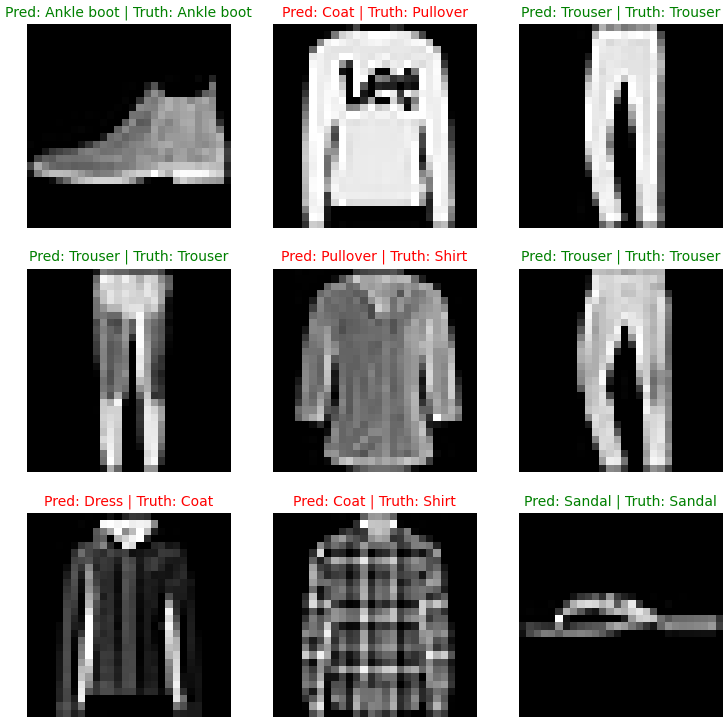

In [91]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_data):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample[0].squeeze(), cmap="gray")
    pred_label = class_names[pred_probs[i]]
    truth_label = class_names[labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
        plt.axis(False);
    else:
        plt.title(title_text, fontsize=10, c="r")
        plt.axis(False);
    if i==8:
        break

test data 에 대한 모델의 prediction 과 실제 label 을 시각화 한 결과, `Anlke boot`, `sandal`, `trouser` 같이 명확한 shape 이 있는 샘플에 대해서는 예측을 잘 하는 것을 볼 수 있다. 하지만 모양이 얼추 비슷한 `coat`, `pullover`, `shirt` 같은 상의는 분류를 잘 못하였다.

Pi-Model 을 학습하는데는 일반 `cpu` 로 약 40분, Temporal Ensembling Model 을 학습하는데 20분으로 약 2배 빨랐다. 이는 Temporal Ensembling Model은 한번의 perturbation 에 한번 evaluation 을 거친다는 장점 덕분이다.

하지만 Temporal Ensembling 의 단점으론 메모리에 $Z$ 를 할당할 공간이 필요하다는 점이 있다. FashionMNIST 는 비교적 작은 데이터셋이므로 큰 memory load 는 없었지만, Pi-Model 에 비해 더 memory intensive 하다. 또한 새로운 가중평균 hyperparameter $\alpha$ 가 추가되기 때문에, model tuning 시 고려해야 하는 경우의 수가 늘어난다.